## Beer Recommendations

### Tasks:

"Could you provide an answer for the following questions":

- ["Which brewery produces the strongest beers by abv ?"](#Strongest-Beers)

- ["If you had to pick 3 beers to recommend to someone, how would you approach the problem?"](#Beer-Recommendations)

- ["What are the factors that impacts the quality of beer the most?"](#Beer-Qlty)

- ["I enjoy a beer which aroma and appearance matches the beer style. What beer should I buy?"](#Beer-Style-Matches)

In [1]:
from scipy.spatial import distance       # for cosine distances
from statsmodels.formula.api import ols  # for patsy formula
from sklearn.preprocessing import scale  # for scaling features
from sklearn.inspection import permutation_importance  # for assessing feature importance
from sklearn.ensemble import RandomForestRegressor  # for it doesn't care about feature scaling

from sklearnex import patch_sklearn      # speeds up sklearn a bit
patch_sklearn()

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
beers = pd.read_csv('beer_reviews.csv')
beers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [3]:
beers.sample(3)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
505869,132,Rogue Ales,1240836832,3.5,3.5,3.5,Ragingbull,Oatmeal Stout,3.0,3.5,Shakespeare Oatmeal Stout,6.1,56973
699066,130,Boulder Beer / Wilderness Pub,1220150169,4.0,4.0,4.0,argock,English India Pale Ale (IPA),4.5,4.0,Cold Hop British-Style Ale,6.8,36468
1138719,863,Russian River Brewing Company,1236241149,4.0,4.0,4.0,olmatty,American IPA,4.0,4.5,Blind Pig IPA,6.1,22790


In [4]:
Num_of_Recommendations = 3
Review_Criteria = ['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

### Strongest Beers

Approach Plan:
- Select the brewery whose beers contain the highest average ABV

In [5]:
f"The brewery that produces the strongest beers by abv is {beers.groupby('brewery_name')['beer_abv'].mean().sort_values(ascending=False).head(1).index.values[0]}."  # max() can be used in place of mean()

'The brewery that produces the strongest beers by abv is Schorschbräu.'

### Beer Recommendations

Approach Plan:
- [Make suggestions based on popular reviews](#Popularity-Recomendation)
- [Make suggestions based on the likings of yours](#Content-Recomendation)
- [Make suggestions based on the likings of like-minded reviewers](#Collaborative-Recomendation) 

#### Popularity Recomendation

In [6]:
Best_Beers_by_Reviews = beers[['beer_name'] + Review_Criteria ].groupby('beer_name').mean().sort_values(by=Review_Criteria, ascending=False).head(Num_of_Recommendations).index
f"The best beers according to the reviews are: {', '.join(Best_Beers_by_Reviews)}"

"The best beers according to the reviews are: Bell's Batch 2000, Bottleworks Imagination Series VIII Laphroaig Barrel Aged Scotch Ale, Chicago Terminal Oatmeal Bourbon Stout"

##### Notes:
- additional criteria can be added, like select only from the popular breweries with above-average reviews, or their review scores are among the top 10%, or simmillar.

#### Content Recomendation

In [7]:
# enter the list of beer names you like (you can use widgets for that)
liked_beer_names = ['Amstel Light',]

# get the df-indices for the liked beers
liked_beers_idxes = beers.query('beer_name in @liked_beer_names').index 
liked_beers_idx = liked_beers_idxes[-1]  # for simplicity just limit the processing to 1 

In [8]:
# scale beers and convert to df 
beers_to_compare = beers[Review_Criteria + ['beer_abv']] # add ABV to the other review criteria
beers_to_compare = pd.DataFrame(scale(beers_to_compare, axis=0), index=beers_to_compare.index, columns=beers_to_compare.columns)  # standardizes features to loc=0, std=1

In [9]:
# select the top Num_of_Recommendations of simillar beers
sorted_recomendation_tuples = sorted( (distance.cosine(beers_to_compare.loc[liked_beers_idx], beers_to_compare.loc[j]),  # computes the distances to the selected beer of liked_beers_idx
                                       j)                                       # j is the index to get hold of beer names
                                            for j in beers_to_compare.index     # loops over all beers
                                                if j not in liked_beers_idxes   # doesn't compare to the selected beers
        
                                    )[:Num_of_Recommendations]

# grab recommended beer indices
recommended_beers_idxes = [r[1] for r in sorted_recomendation_tuples]

# and translate them to their names
recommended_beer_names = beers.query("index in @recommended_beers_idxes").beer_name.unique().tolist()
f"The recommened beers based on your current liknings are: {', '.join(recommended_beer_names)}"

'The recommened beers based on your current liknings are: Sierra Nevada Wheat Beer, Cable Car Small Batch Amber Ale'

#### Collaborative Recomendation

Approach Plan:
- Based on the review_profilename (review_id), select like-mided reviewers, then recommend beers that those reviewers value highly.
- Since the data size is quite large, limit the reviewers only to those that reviewed between 10 and 100 beers.
- Then to speed up the processing, decompse/factorize the matrix M, from the format |reviwer_id(index)\beer_id(columns|(with overall ratings as values|, into R @ B, where R represents reviews and B beers (alternatively into R @ np.diag(s) @ B) so that computing similarities for reviews and beers is much faster

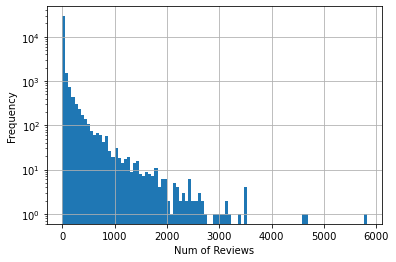

In [5]:
# viz the "Num of Review" dist
beers.groupby('review_profilename').size().plot.hist(bins=99) 
plt.xlabel("Num of Reviews"); plt.yscale('log'); plt.grid()

In [37]:
# factorize review_profilename
beers['review_id'] = pd.factorize(beers.review_profilename, na_sentinel=-1)[0]
beers_for_colla_recom = beers[['review_id', 'beer_beerid', 'review_overall']].dropna()
beers_for_colla_recom = beers_for_colla_recom.query('review_id >= 0')  # discard those rows that had no review_id
beers_for_colla_recom = beers_for_colla_recom.groupby(['review_id','beer_beerid']).mean()

# limit the num of rows
review_counts = beers_for_colla_recom.groupby(level=0).size()
reviews_idxes_with_many_beers = review_counts[(20>review_counts) & (review_counts>10)].index.values

beers_reduced = beers_for_colla_recom.reset_index().query('review_id in @reviews_idxes_with_many_beers')
beers_reduced

,review_id,beer_beerid,review_overall
19658,19,944,3.0
19659,19,1160,4.5
19660,19,5488,4.0
19661,19,20897,3.5
19662,19,35608,4.5
...,...,...,...
1569801,31904,70375,4.5
1569802,31904,70376,4.0
1569803,31904,70388,3.5
1569804,31904,70389,3.0


### Beer Qlty

Approach Plan:
- [Build the OLS model the coef of which will signify the impact on the overall Qlty](#OLS-coefs)
- [Alternatively, use a permutaion importance method with some model (say, linear or trees ensemble model)](#Permutaion-Importances)
- [Better yet, try SHAP](#SHAP)

#### OLS coefs

In [13]:
model = ols(formula='review_overall ~ review_aroma + review_appearance + review_palate + review_taste + beer_abv', data=beers)  
# Caveat: beer_abv needs to be brought on the same scale as the other features, otherwise its coef is misleading

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         review_overall   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     384.8
Date:                Sun, 13 Jun 2021   Prob (F-statistic):          9.83e-226
Time:                        21:42:48   Log-Likelihood:                -547.16
No. Observations:                 959   AIC:                             1106.
Df Residuals:                     953   BIC:                             1136.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4962      0.098      5.083      0.000       0.305       0.688
review_aroma          0.0257      0.031      0.836      0.403      -0.035       0.086
review_appearance     0.0708      0.028      2.495      0.013       0.015       0.126
review_palate         0.1759      0.031      5.676      0.000       0.115       0.237
review_taste          0.6850      0.031     22.210      0.000       0.624       0.746
beer_abv             -0.0430      0.007     -6.437      0.000      -0.056      -0.030
==============================================================================
Omnibus:                       32.971   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.534
Skew:                           0.018   Prob(JB):                     4.40e-19
Kurtosis:                       4.454   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

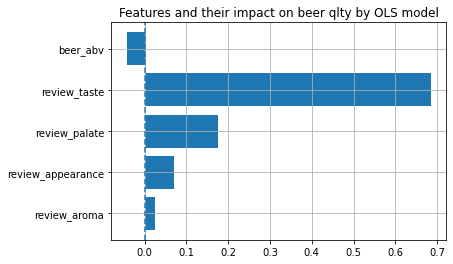

In [14]:
coef_table = res.summary().tables[1].data[2:]  # gets hold of the second - ie coef - table
feature_and_coef_tuples = [(r[0],float(r[1])) for r in coef_table]
plt.barh(*list(zip(*feature_and_coef_tuples)))
plt.axvline(0, ls='--'); plt.grid()
plt.title("Features and their impact on beer qlty by OLS model");

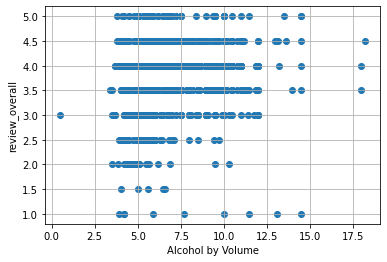

In [15]:
plt.scatter(beers.beer_abv, beers.review_overall)
plt.ylabel("review_overall"); plt.xlabel("Alcohol by Volume"); plt.grid();

##### Notes:
- **coef**, in the above table, signifies the impact of factors on the beer qlty according to the OLS model (where **P[t]** denotes the probability that the impact is accutally due to a chance, ie the lower it is the more significant the score)

#### Permutaion Importances

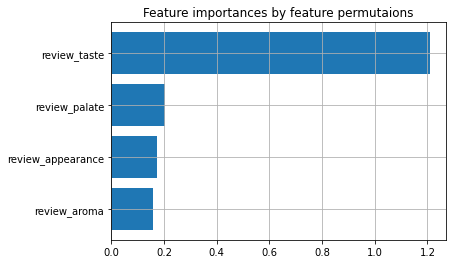

In [16]:
beer_nonull = beers.dropna()

X = beer_nonull[Review_Criteria[1:]]
y = beer_nonull['review_overall']

# from sklearn.linear_model import LinearRegression
# model = LinearRegression().fit(X, y)
model = RandomForestRegressor().fit(X, y)

# calc the importances
result = permutation_importance(model, X, y, n_repeats=10)

# plot the importances
zipped_list = list(zip(X.columns, result.importances_mean))
unzipped_list = list(zip(*zipped_list))
plt.barh(*unzipped_list)
plt.grid()
plt.title('Feature importances by feature permutaions');

#### SHAP

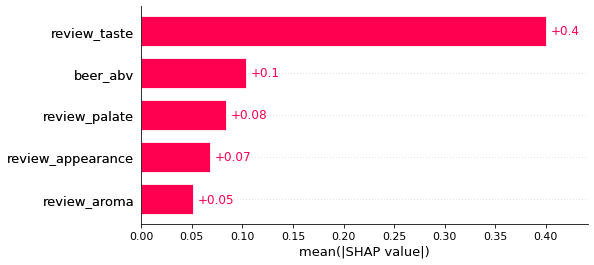

In [17]:
import shap

beer_nonull = beers.dropna()
X = beer_nonull[Review_Criteria[1:] + ['beer_abv']]
y = beer_nonull['review_overall']

model = RandomForestRegressor().fit(X, y)

explainer = shap.explainers.Exact(model.predict, X)
shap_values = explainer(X[:1000], silent=True)
shap.plots.bar(shap_values)

### Beer Style Matches

Approach Plan:
- Assumption: the question is about what style will be enjoyed the most, given aroma and appearance have the biggest significance

In [18]:
Num_of_Recommendations = 3
Reccomended_Beers = (beers[['beer_style','review_aroma','review_appearance']]
                        .groupby('beer_style')
                        .mean()
                        .assign(enjoyment=lambda f: f.review_aroma + f.review_appearance)
                        .sort_values(by='enjoyment', ascending=False)
                        .head(Num_of_Recommendations)
                        .index
                        .tolist()
                    )
f"If you enjoy aroma and appeariance you should try these: {', '.join(Reccomended_Beers)}"

'If you enjoy aroma and appeariance you should try these: Lambic - Unblended, Gueuze, English Stout'

#### THE END